# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** **J**

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import csv
import os

---

## 2.1 Exploration of real networks

#### Exercise 2.1
Your first task is to explore network1 and analyze its properties.<br>
1.  Load the graph in your favorite data structure.<br>
2.  How many nodes and edges does the graph contain?

In [46]:
with open('../data/network1.csv') as file:
    data=[tuple(line) for line in csv.reader(filter(lambda row: row[0]!='#', file))]

G = nx.Graph(data)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 13033
Number of edges: 18584


#### Exercise 2.2:  Node degree distribution

In [45]:
from scipy.stats import pareto

def node_degree_distribution(G):
    degrees = np.fromiter(dict(G.degree()).values(), dtype=int)
    values = np.bincount(degrees)
    b, loc, scale = pareto.fit(degrees, 1) # Fitting a pareto distribution to the data

    figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    plt.hist(degrees[degrees < 35], 35, label='Real data', log=True)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    np.random.seed(10)
    pareto_numbers = pareto.rvs(b, loc, scale, len(degrees))
    plt.hist(pareto_numbers, 35, label='Real data', log=True)
    plt.legend()

    cumulative = np.cumsum(values)
    plt.subplot(2,2,3)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes with degree larger than x")
    plt.plot(cumulative[:20], label='Real data')
    plt.plot([pareto.cdf(x+1, b, loc, scale)*len(degrees) for x in range(20)], label='Approximated pareto distribution')
    plt.legend()

/home/vescovo/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


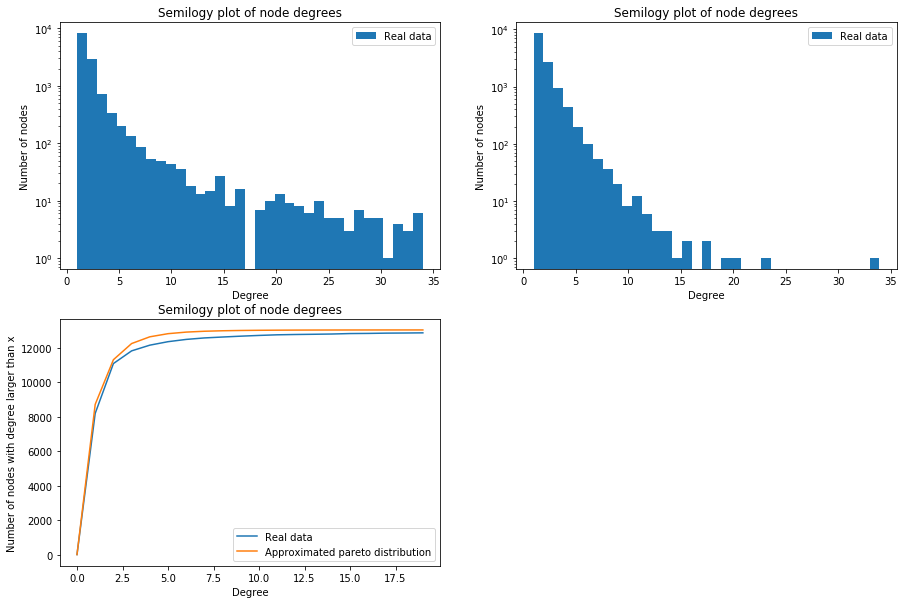

In [47]:
node_degree_distribution(G)

#### Answer:
2. No node has degree = 0, which was to be expected since we constructed the graph from a set of edges. The degree of the nodes falls off exponentially. 
3. 

#### Exercise 2.3: Giant component

In [5]:
conn_components = sorted(nx.connected_components(G), key = len, reverse=True)
print('# of connected components:', len(conn_components))
print('Size of largest component:', len(conn_components[0]))
print('Size of second largest component:', len(conn_components[1]))

# of connected components: 192
Size of largest component: 12576
Size of second largest component: 16


The difference of size between the two largest components is huge. So we can say that the largest component is the giant component.

#### Exercise 2.4: Short paths & Small-worlds

In [14]:
avg = nx.average_shortest_path_length(G.subgraph(conn_components[0]))

KeyboardInterrupt: 

In [43]:
def reachable_nodes_in_k_hops(s, node, k):
    if k < 1:
        return s
    
    for n in set(G.neighbors(node)) - s:  # iterate over neighbours of node that are not in s yet
        s.add(n)
        s = s | reachable_nodes_in_k_hops(s, n, k-1)
        
    return s

In [35]:
gc = list(conn_components[0])
res = np.zeros((100, 6))
for i in range(100):
    for j in range(6):
        print('start')
        np.random.seed(i)
        s = reachable_nodes_in_k_hops(set(), np.random.choice(gc), j+1)
        res[i, j] = len(s)

    print('\r Progress: %d' % (i+1),'/', 100, end='' )
means = np.mean(res, axis=0)

[ 2.67246616 -0.68214145]


Text(0.5, 0, '# of hops')

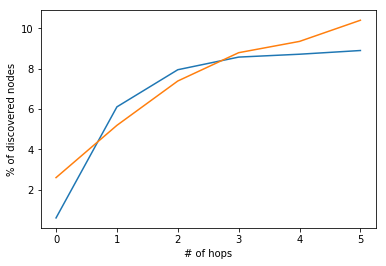

In [37]:
plt.plot(np.log(means))
plt.ylabel("% of discovered nodes")
plt.xlabel("# of hops")

The average shortest path of 4 hops is an indicator

#### Exercise 2.5: Network comparison

In [48]:
with open('../data/network2.csv') as file:
    data=[tuple(line) for line in csv.reader(filter(lambda row: row[0]!='#', file))]

G2 = nx.Graph(data)
print('Number of nodes:', G2.number_of_nodes())
print('Number of edges:', G2.number_of_edges())

Number of nodes: 26542
Number of edges: 43516


/home/vescovo/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


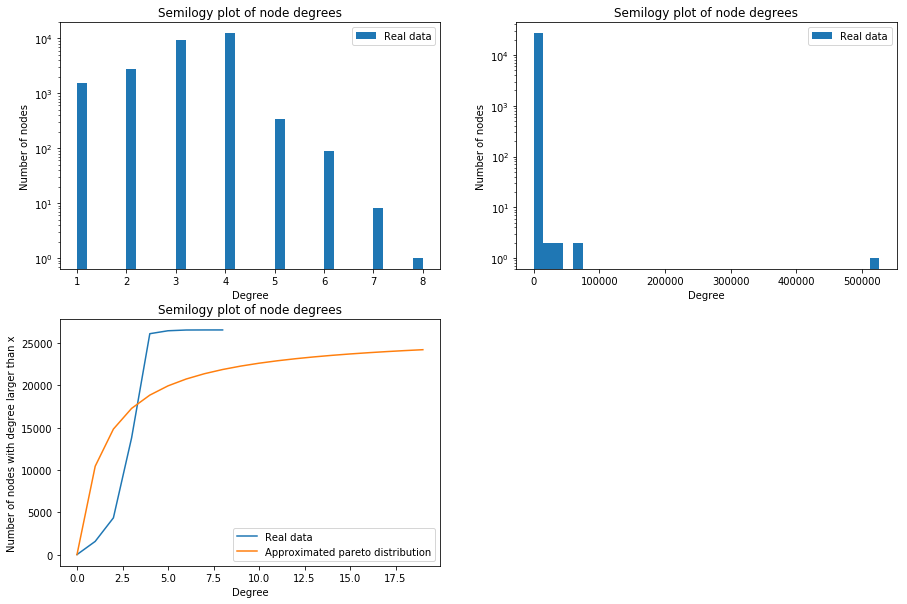

In [49]:
node_degree_distribution(G2)

In [51]:
conn_components = sorted(nx.connected_components(G2), key = len, reverse=True)
print('# of connected components:', len(conn_components))
print('Size of largest component:', len(conn_components[0]))
print('Size of second largest component:', len(conn_components[1]))

# of connected components: 5
Size of largest component: 26481
Size of second largest component: 30


In [ ]:
avg = nx.average_shortest_path_length(G2.subgraph(conn_components[0]))

#### Exercise 2.6: Network identification